## Demonstrate evaluating the surrogate model and unit transformations
This model was trained by Auralee to predict beam properties at OTR2 using injector
PVs for LCLS.

In [1]:
import json
import torch
import pprint

model_info = json.load(open("configs/model_info.json"))
pv_info = json.load(open("configs/pv_info.json"))
nn_transform_info = json.load(open("configs/normalization.json"))
pprint.pprint(model_info)
pprint.pprint(pv_info)


{'loc_in': {'CQ01:b1_gradient': 4,
            'L0A_phase:dtheta0_deg': 7,
            'L0A_scale:voltage': 6,
            'L0B_phase:dtheta0_deg': 9,
            'L0B_scale:voltage': 8,
            'QA01:b1_gradient': 10,
            'QA02:b1_gradient': 11,
            'QE01:b1_gradient': 12,
            'QE02:b1_gradient': 13,
            'QE03:b1_gradient': 14,
            'QE04:b1_gradient': 15,
            'SOL1:solenoid_field_scale': 3,
            'SQ01:b1_gradient': 5,
            'distgen:r_dist:sigma_xy:value': 0,
            'distgen:t_dist:length:value': 1,
            'distgen:total_charge:value': 2},
 'loc_out': {'norm_emit_x': 3,
             'norm_emit_y': 4,
             'sigma_x': 0,
             'sigma_y': 1,
             'sigma_z': 2},
 'model_in_list': ['distgen:r_dist:sigma_xy:value',
                   'distgen:t_dist:length:value',
                   'distgen:total_charge:value',
                   'SOL1:solenoid_field_scale',
                   'CQ01:b1_gradien

In [2]:
# view bounds of training data
[[ele1, ele2] for ele1, ele2 in zip(model_info["train_input_mins"],
                                    model_info["train_input_maxs"])]

[[0.21021247820852546, 0.4999996083265339],
 [3.000000758511308, 11.998569812014836],
 [250.0, 250.0],
 [0.19409053333889578, 0.2563030896232562],
 [-0.009999618141995313, 0.0099925212795954],
 [-0.009999490058927914, 0.009999443099573097],
 [58000000.0, 58000000.0],
 [-24.998714513984325, 9.991752397382681],
 [70000000.0, 70000000.0],
 [-24.99972566363747, 9.998904767155892],
 [1.000039854940649, 3.998197816908352],
 [-3.990444304119449, -1.0105116218007806],
 [1.0007061999094193, 6.9997773994714345],
 [-6.999887318319171, 0.9983521010385275],
 [-6.998418428856965, 0.9993010487139868],
 [1.000026533968218, 6.998086093251312]]

In [3]:
pprint.pprint(nn_transform_info)

{'x_min': [-0.708149054,
           -0.32005256,
           -247.49,
           -3.07859882,
           0.505175716,
           0.505001162,
           -57420000.0,
           0.717299146,
           -69300000.0,
           0.717162769,
           -0.320215909,
           1.33571446,
           -0.155142087,
           0.876426732,
           0.876301233,
           -0.155057759],
 'x_scale': [3.41630078,
             0.110017492,
             0.99,
             15.9131863,
             49.5194626,
             49.5026406,
             0.99,
             0.0282934207,
             0.99,
             0.0282868212,
             0.330202749,
             0.33222227,
             0.165025546,
             0.12377724,
             0.123785287,
             0.165053379],
 'y_min': [0.00834951, 0.00885094, -0.67912807, -0.08841661, -0.08485377],
 'y_scale': [229.572091, 172.618777, 1754.24967, 226993.39, 191052.997]}


## Demonstrate NN model

In [4]:
from transformers import create_sim_to_nn_transformers
from transformed_model import KeyedTransformedModel
# get transformers for normailzation into NN
nn_input_transformer, nn_output_transformer = create_sim_to_nn_transformers(
    "configs/normalization.json"
)
test_min = torch.tensor(model_info["train_input_mins"])
test_max = torch.tensor(model_info["train_input_maxs"]).unsqueeze(0)

# validate input transformers
print(nn_input_transformer(test_min))
print(nn_input_transformer(test_max))

model = torch.load("torch_model.pt").double()

# define the NN surrogate that contains the NN, the input/output transformers for
# simulation units
surrogate = KeyedTransformedModel(
    model,
    nn_input_transformer,
    nn_output_transformer,
    model_info["model_in_list"],
    model_info["model_out_list"]
)


tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0000, 0.0100, 0.0000,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100])
tensor([[1.0000, 1.0000, 0.0100, 1.0000, 1.0000, 1.0000, 0.0000, 1.0000, 0.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]])


In [5]:
import numpy as np
raw_x_data = np.load("data/x_raw_small.npy", allow_pickle=True)
raw_y_data = np.load("data/y_raw_small.npy", allow_pickle=True)

preds = surrogate(torch.tensor(raw_x_data).double())

print(raw_x_data[0])
print(raw_y_data[0])
print(preds[0])

[ 3.92211981e-01  5.83776995e+00  2.50000000e+02  2.29980597e-01
  3.92231489e-04 -6.47414040e-03  5.80000000e+07  2.79354164e+00
  7.00000000e+07 -9.86897001e+00  2.14861067e+00 -2.41573625e+00
  2.40720925e+00  7.18128851e-01 -3.74875980e+00  2.33949758e+00]
[0.00016864793055100324 0.0015950831162394174 0.0005424259007070327
 1.3960860485109939e-06 1.1762668344852966e-06]
tensor([1.7824e-04, 1.4451e-03, 5.4184e-04, 1.4162e-06, 1.1945e-06],
       dtype=torch.float64)


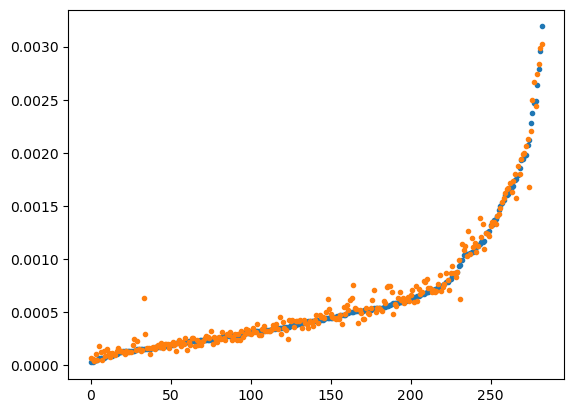

In [6]:
import matplotlib.pyplot as plt

# sort by y values
sort_idx = np.argsort(raw_y_data[:,0])

# these datasets should overlap
fig,ax = plt.subplots()
ax.plot(raw_y_data[:,0][sort_idx],".")
ax.plot(preds[:,0][sort_idx],".")